# **SETUP DAN IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (cross_val_score, StratifiedKFold, learning_curve,
                                   validation_curve, cross_validate)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print("🔍 Starting Comprehensive Model Evaluation...")

✅ All libraries imported successfully!
🔍 Starting Comprehensive Model Evaluation...


# **LOAD AND PREPARE DATA**

In [ ]:
print("\n" + "="*60)
print("📁 DATA LOADING AND PREPARATION")
print("="*60)

# Upload dataset
from google.colab import files

print("📁 Please upload your AI Assistant Usage dataset:")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
# ⬇️ Hanya baca 1000 baris pertama
df_original = pd.read_csv(filename, nrows=1000)

# Replicate preprocessing from previous notebooks
df = df_original.copy()

# Handle missing values
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')
    else:
        df[col] = df[col].fillna(df[col].median())

# Remove duplicates
df = df.drop_duplicates()

print(f"✅ Dataset prepared: {df.shape[0]} rows × {df.shape[1]} columns")

# Identify features and target
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Identify target variable
potential_targets = []
for col in categorical_cols:
    unique_count = df[col].nunique()
    if 2 <= unique_count <= 20:
        if any(keyword in col.lower() for keyword in ['category', 'type', 'class', 'usage', 'purpose', 'label']):
            potential_targets.append(col)

if not potential_targets:
    for col in categorical_cols:
        if 2 <= df[col].nunique() <= 10:
            potential_targets.append(col)
            break

if not potential_targets:
    # Create synthetic target
    df['usage_pattern'] = np.random.choice(['Academic', 'Personal', 'Creative'], size=len(df))
    potential_targets = ['usage_pattern']

target_col = potential_targets[0]
print(f"🎯 Target variable: {target_col}")
print(f"Classes: {df[target_col].value_counts().to_dict()}")

# Prepare features (simplified feature engineering)
feature_dfs = []

# Encode categorical features
categorical_features = [col for col in categorical_cols if col != target_col]
for col in categorical_features:
    if df[col].nunique() <= 10:
        encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
        feature_dfs.append(encoded)
    else:
        le = LabelEncoder()
        encoded_series = pd.Series(le.fit_transform(df[col].astype(str)),
                                 name=f"{col}_encoded", index=df.index)
        feature_dfs.append(pd.DataFrame(encoded_series))

# Scale numerical features
if numerical_cols:
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numerical_cols])
    scaled_df = pd.DataFrame(scaled_data,
                           columns=[f"{col}_scaled" for col in numerical_cols],
                           index=df.index)
    feature_dfs.append(scaled_df)

# Create feature matrix
if feature_dfs:
    X = pd.concat(feature_dfs, axis=1)
else:
    X = df[numerical_cols] if numerical_cols else pd.DataFrame(index=df.index)

# Prepare target
le_target = LabelEncoder()
y = le_target.fit_transform(df[target_col])
target_classes = le_target.classes_

# Clean data
X = X.fillna(0).replace([np.inf, -np.inf], 0)

print(f"📊 Final dataset: {X.shape[0]} samples × {X.shape[1]} features")
print(f"🎯 Target classes: {len(target_classes)} classes")



📁 DATA LOADING AND PREPARATION
📁 Please upload your AI Assistant Usage dataset:


Saving ai_assistant_usage_student_life.csv to ai_assistant_usage_student_life.csv
✅ Dataset prepared: 1000 rows × 11 columns
🎯 Target variable: TaskType
Classes: {'Writing': 293, 'Studying': 226, 'Coding': 204, 'Homework Help': 194, 'Brainstorming': 43, 'Research': 40}
📊 Final dataset: 1000 samples × 17 features
🎯 Target classes: 6 classes


# **CROSS-VALIDATION EVALUATION**

Kode ini berfungsi untuk **mengevaluasi beberapa model machine learning menggunakan cross-validation** dan membandingkan kinerjanya di berbagai metrik.
Berikut deskripsi ringkasnya:

---

### **1. Tujuan**

Melakukan **5-fold cross-validation** untuk menilai performa model dengan **beberapa metrik** (accuracy, precision, recall, F1-score) baik pada data train maupun test, lalu menyimpannya untuk analisis.

---

### **2. Langkah Utama**

1. **Menyiapkan daftar model**

   * Random Forest
   * Gradient Boosting
   * Logistic Regression
   * Support Vector Machine
   * Naive Bayes *(opsional, hanya jika jumlah fitur > 50)*

2. **Menentukan strategi validasi**

   * Menggunakan `StratifiedKFold` agar distribusi kelas seimbang di tiap fold.
   * Jumlah fold = 5, data diacak (`shuffle=True`), dan `random_state=42` untuk reprodusibilitas.

3. **Menjalankan evaluasi**

   * `cross_validate` digunakan untuk menghitung skor di beberapa metrik sekaligus (`accuracy`, `precision_weighted`, `recall_weighted`, `f1_weighted`).
   * Hasil evaluasi mencakup skor pada **train** dan **test** untuk semua metrik.

4. **Menyimpan hasil**

   * Skor per model disimpan dalam dictionary `cv_results`.
   * Menampilkan ringkasan:

     * Rata-rata & standar deviasi akurasi test.
     * Rata-rata & standar deviasi F1 test.
     * Selisih akurasi train dan test (*train-test gap*) untuk indikasi overfitting.

5. **Penanganan error**

   * Jika ada model gagal dievaluasi (misalnya parameter tidak cocok dengan data), error akan ditangkap dan ditampilkan tanpa menghentikan proses.

---

### **3. Insight yang bisa didapat**

* Model mana yang memiliki **akurasi dan F1 terbaik**.
* Apakah model overfit (jika train-test gap terlalu besar).
* Perbandingan performa antar model di berbagai metrik, bukan hanya akurasi.

---

Kalau mau, aku bisa buatkan **versi output yang lebih rapi** untuk kode ini, mirip yang kita lakukan di bagian *prediction examples*.
Itu akan membuat hasil evaluasinya lebih mudah dibaca dan dibandingkan.


In [ ]:
print("\n" + "="*60)
print("🔄 CROSS-VALIDATION EVALUATION")
print("="*60)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

# Add Naive Bayes for high-dimensional data
if X.shape[1] > 50:
    models['Naive Bayes'] = MultinomialNB()

# Perform cross-validation
cv_results = {}
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

print("🔄 Performing 5-fold cross-validation...")

for name, model in models.items():
    print(f"\n📊 Evaluating {name}...")

    try:
        # Multiple scoring metrics
        scores = cross_validate(model, X, y, cv=cv_folds,
                              scoring=scoring_metrics, return_train_score=True)

        cv_results[name] = {
            'test_accuracy': scores['test_accuracy'],
            'test_precision': scores['test_precision_weighted'],
            'test_recall': scores['test_recall_weighted'],
            'test_f1': scores['test_f1_weighted'],
            'train_accuracy': scores['train_accuracy'],
            'train_precision': scores['train_precision_weighted'],
            'train_recall': scores['train_recall_weighted'],
            'train_f1': scores['train_f1_weighted'],
        }

        # Print summary
        print(f"  ✅ Test Accuracy: {scores['test_accuracy'].mean():.4f} (±{scores['test_accuracy'].std():.4f})")
        print(f"  🎯 Test F1-Score: {scores['test_f1_weighted'].mean():.4f} (±{scores['test_f1_weighted'].std():.4f})")
        print(f"  📈 Train-Test Gap: {(scores['train_accuracy'].mean() - scores['test_accuracy'].mean()):.4f}")

    except Exception as e:
        print(f"  ❌ Error evaluating {name}: {str(e)}")



🔄 CROSS-VALIDATION EVALUATION
🔄 Performing 5-fold cross-validation...

📊 Evaluating Random Forest...
  ✅ Test Accuracy: 0.2710 (±0.0320)
  🎯 Test F1-Score: 0.2543 (±0.0302)
  📈 Train-Test Gap: 0.7290

📊 Evaluating Gradient Boosting...
  ✅ Test Accuracy: 0.2760 (±0.0410)
  🎯 Test F1-Score: 0.2588 (±0.0380)
  📈 Train-Test Gap: 0.6130

📊 Evaluating Logistic Regression...
  ✅ Test Accuracy: 0.2850 (±0.0230)
  🎯 Test F1-Score: 0.2522 (±0.0205)
  📈 Train-Test Gap: 0.0608

📊 Evaluating Support Vector Machine...
  ✅ Test Accuracy: 0.2930 (±0.0024)
  🎯 Test F1-Score: 0.1328 (±0.0020)
  📈 Train-Test Gap: -0.0000


# **PERFORMANCE COMPARISON**

Potongan kode ini adalah tahap **membandingkan performa model** berdasarkan hasil cross-validation (`cv_results`).

Rinciannya:

1. **Membangun DataFrame Perbandingan**

   * Loop setiap model di `cv_results`.
   * Mengambil **rata-rata** (`mean`) dan **deviasi standar** (`std`) untuk metrik:

     * Accuracy (`test_accuracy`)
     * F1-score (`test_f1`)
     * Precision (`test_precision`)
     * Recall (`test_recall`)
   * Menghitung **Overfitting\_Score** = `train_accuracy_mean - test_accuracy_mean`.

2. **Membuat DataFrame `comparison_df`**

   * Menampilkan tabel ringkasan dengan pembulatan 4 desimal.

3. **Menentukan model terbaik**

   * Mengambil model dengan **Test\_F1\_Mean tertinggi**.
   * Menampilkan **nama model**, **F1-score**, dan **Accuracy** lengkap dengan ± standard deviation.

Kalau mau, aku bisa bikin **heatmap visualisasi performa antar-model** dari `comparison_df` supaya lebih mudah melihat model yang unggul.


In [ ]:
print("\n" + "="*60)
print("📊 PERFORMANCE COMPARISON")
print("="*60)

# Create comparison DataFrame
comparison_data = []
for name, results in cv_results.items():
    comparison_data.append({
        'Model': name,
        'Test_Accuracy_Mean': results['test_accuracy'].mean(),
        'Test_Accuracy_Std': results['test_accuracy'].std(),
        'Test_F1_Mean': results['test_f1'].mean(),
        'Test_F1_Std': results['test_f1'].std(),
        'Test_Precision_Mean': results['test_precision'].mean(),
        'Test_Recall_Mean': results['test_recall'].mean(),
        'Overfitting_Score': results['train_accuracy'].mean() - results['test_accuracy'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
print("🏆 Model Performance Comparison (Cross-Validation):")
print(comparison_df.round(4))

# Find best model
best_model_idx = comparison_df['Test_F1_Mean'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
print(f"\n🥇 Best Model: {best_model_name}")
print(f"   📊 F1-Score: {comparison_df.loc[best_model_idx, 'Test_F1_Mean']:.4f} (±{comparison_df.loc[best_model_idx, 'Test_F1_Std']:.4f})")
print(f"   🎯 Accuracy: {comparison_df.loc[best_model_idx, 'Test_Accuracy_Mean']:.4f} (±{comparison_df.loc[best_model_idx, 'Test_Accuracy_Std']:.4f})")



📊 PERFORMANCE COMPARISON
🏆 Model Performance Comparison (Cross-Validation):
                    Model  Test_Accuracy_Mean  Test_Accuracy_Std  \
0           Random Forest               0.271             0.0320   
1       Gradient Boosting               0.276             0.0410   
2     Logistic Regression               0.285             0.0230   
3  Support Vector Machine               0.293             0.0024   

   Test_F1_Mean  Test_F1_Std  Test_Precision_Mean  Test_Recall_Mean  \
0        0.2543       0.0302               0.2478             0.271   
1        0.2588       0.0380               0.2584             0.276   
2        0.2522       0.0205               0.2518             0.285   
3        0.1328       0.0020               0.0859             0.293   

   Overfitting_Score  
0             0.7290  
1             0.6130  
2             0.0608  
3            -0.0000  

🥇 Best Model: Gradient Boosting
   📊 F1-Score: 0.2588 (±0.0380)
   🎯 Accuracy: 0.2760 (±0.0410)


# **LEARNING CURVES**

Potongan kode ini digunakan untuk **menganalisis kurva pembelajaran (learning curves)** dari model terbaik berdasarkan hasil perbandingan sebelumnya.

Ringkasannya:

1. **Memilih model**

   * Ambil 3 model dengan nilai `Test_F1_Mean` tertinggi dari `comparison_df`.
   * Tambahkan *Support Vector Machine* (SVM) jika tidak masuk 3 besar, untuk pengecekan manual.

2. **Menyiapkan subplots**

   * Membuat layout `fig, axes` sebanyak jumlah model yang dianalisis.

3. **Membuat learning curve untuk tiap model**

   * Menggunakan `learning_curve()` dari scikit-learn:

     * 10 titik data (`train_sizes`) dari 10% hingga 100% dataset.
     * *Cross-validation* 3 kali (`cv=3`).
     * Metrik: `f1_weighted`.
   * Menghitung rata-rata (`mean`) dan deviasi standar (`std`) untuk *training score* dan *validation score*.

4. **Plotting hasil**

   * Garis biru: skor training.
   * Garis merah: skor validasi.
   * Area transparan = rentang ± standar deviasi.
   * Grid dan label ditambahkan untuk keterbacaan.

📌 Hasilnya akan menunjukkan **apakah model overfitting, underfitting, atau seimbang**.
Misalnya:

* **Overfitting** → training score tinggi, validation score rendah.
* **Underfitting** → kedua skor rendah.
* **Balanced** → kedua skor tinggi dan saling mendekat.

Kalau mau, aku bisa bantu bikin **interpretasi otomatis** dari plot learning curve ini supaya langsung tahu model mana yang paling stabil.



📈 LEARNING CURVES ANALYSIS
📊 Generating learning curve for Gradient Boosting...
📊 Generating learning curve for Random Forest...
📊 Generating learning curve for Logistic Regression...
📊 Generating learning curve for Support Vector Machine...


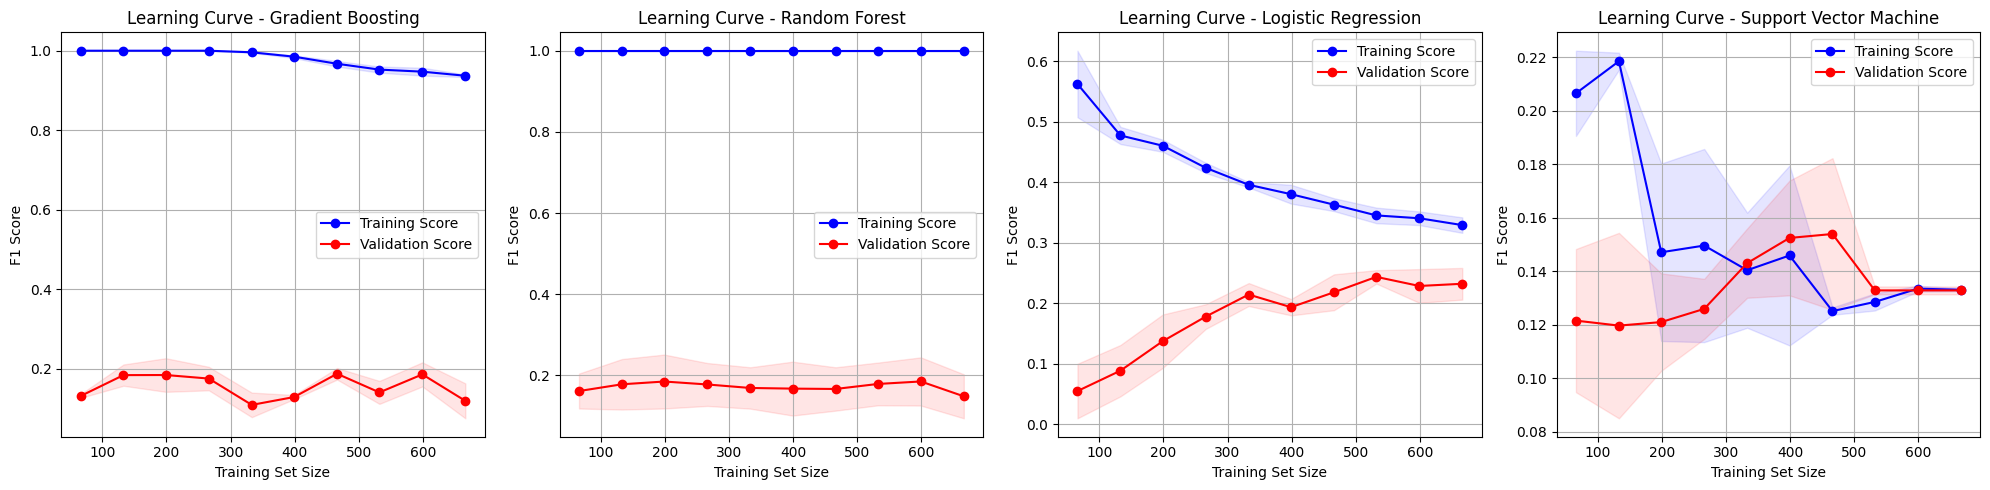

In [ ]:
print("\n" + "="*60)
print("📈 LEARNING CURVES ANALYSIS")
print("="*60)

# Generate learning curves for best models (top 3)
top_models = comparison_df.nlargest(3, 'Test_F1_Mean')['Model'].tolist()

# Menambahkan SVM hanya untuk pengecekan manual
if 'Support Vector Machine' in models and 'Support Vector Machine' not in top_models:
    top_models.append('Support Vector Machine')

fig, axes = plt.subplots(1, len(top_models), figsize=(5*len(top_models), 5))
if len(top_models) == 1:
    axes = [axes]


for i, model_name in enumerate(top_models):
    print(f"📊 Generating learning curve for {model_name}...")

    model = models[model_name]

    # Calculate learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=3, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='f1_weighted'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot learning curve
    axes[i].plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    axes[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

    axes[i].plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    axes[i].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

    axes[i].set_title(f'Learning Curve - {model_name}')
    axes[i].set_xlabel('Training Set Size')
    axes[i].set_ylabel('F1 Score')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# **VALIDATION CURVES (HYPERPARAMETER SENSITIVITY)**

**Kode ini bertujuan untuk:**



*   Mengevaluasi bagaimana perubahan nilai hiperparameter memengaruhi performa model (skor F1) pada data pelatihan dan validasi.
*   Mengidentifikasi nilai hiperparameter optimal yang memberikan performa terbaik pada data validasi.

* Memvisualisasikan hubungan antara hiperparameter dan performa model untuk membantu memahami sensitivitas model terhadap pengaturan hiperparameter.


🔧 VALIDATION CURVES - HYPERPARAMETER SENSITIVITY
📊 Analyzing n_estimators sensitivity for Gradient Boosting...


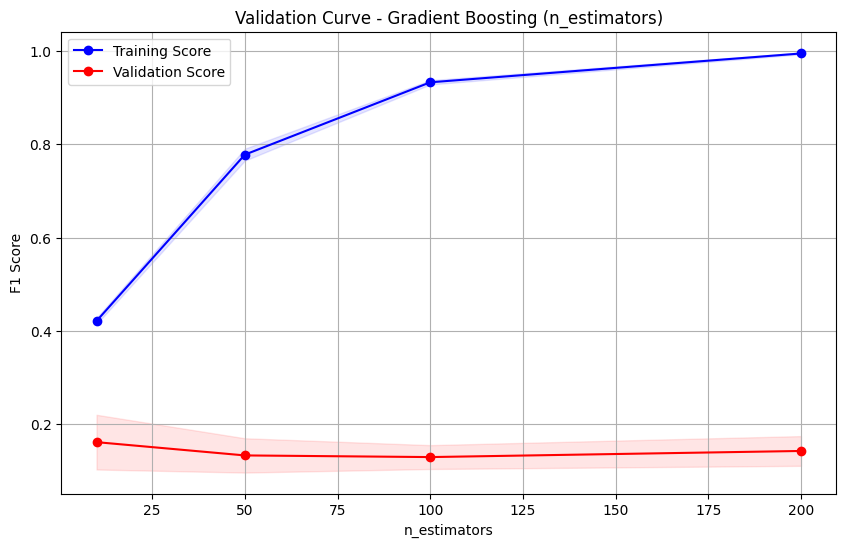

🎯 Optimal n_estimators: 10
📊 Best validation score: 0.1614 (±0.0586)


In [ ]:
print("\n" + "="*60)
print("🔧 VALIDATION CURVES - HYPERPARAMETER SENSITIVITY")
print("="*60)

# Analyze hyperparameter sensitivity for best model
best_model = models[best_model_name]

if best_model_name == 'Random Forest':
    param_name = 'n_estimators'
    param_range = [10, 50, 100, 200, 500]
elif best_model_name == 'Gradient Boosting':
    param_name = 'n_estimators'
    param_range = [10, 50, 100, 200]
elif best_model_name == 'Logistic Regression':
    param_name = 'C'
    param_range = [0.01, 0.1, 1.0, 10.0, 100.0]
elif best_model_name == 'Support Vector Machine':
    param_name = 'C'
    param_range = [0.1, 1.0, 10.0, 100.0]
else:
    param_name = None
    param_range = None

if param_name and param_range:
    print(f"📊 Analyzing {param_name} sensitivity for {best_model_name}...")

    train_scores, val_scores = validation_curve(
        best_model, X, y, param_name=param_name, param_range=param_range,
        cv=3, scoring='f1_weighted', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')

    plt.plot(param_range, val_mean, 'o-', color='red', label='Validation Score')
    plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

    plt.title(f'Validation Curve - {best_model_name} ({param_name})')
    plt.xlabel(param_name)
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    if param_name == 'C':
        plt.xscale('log')
    plt.show()

    # Find optimal parameter
    optimal_idx = np.argmax(val_mean)
    optimal_param = param_range[optimal_idx]
    print(f"🎯 Optimal {param_name}: {optimal_param}")
    print(f"📊 Best validation score: {val_mean[optimal_idx]:.4f} (±{val_std[optimal_idx]:.4f})")


# **FEATURE IMPORTANCE ANALYSIS**

Kode ini bertujuan untuk:

* Mengidentifikasi fitur-fitur yang paling berpengaruh terhadap prediksi model
terbaik.
* Membandingkan dua pendekatan analisis pentingnya fitur:

  * **Feature Importance** (berbasis model, khususnya untuk model berbasis pohon seperti Random Forest).
  * **Permutation Importance** (lebih umum, dapat digunakan untuk semua jenis model dan lebih robust karena mengukur dampak pengacakan fitur).

* Memvisualisasikan hasil analisis dalam bentuk plot batang untuk memudahkan interpretasi.
* Memberikan wawasan tentang fitur mana yang paling penting untuk meningkatkan performa model atau untuk pengambilan keputusan lebih lanjut.


🎯 FEATURE IMPORTANCE ANALYSIS
📊 Analyzing feature importance for Gradient Boosting...
Top 15 Most Important Features:
                        feature  importance
0             SessionID_encoded    0.268440
13      SessionLengthMin_scaled    0.266124
9           SessionDate_encoded    0.179068
16    SatisfactionRating_scaled    0.074078
14          TotalPrompts_scaled    0.054971
12    FinalOutcome_Idea Drafted    0.028219
15    AI_AssistanceLevel_scaled    0.024302
5        Discipline_Engineering    0.016344
10        FinalOutcome_Confused    0.016259
1      StudentLevel_High School    0.015076
2    StudentLevel_Undergraduate    0.012802
4   Discipline_Computer Science    0.012280
8         Discipline_Psychology    0.010035
7               Discipline_Math    0.007997
3           Discipline_Business    0.006009


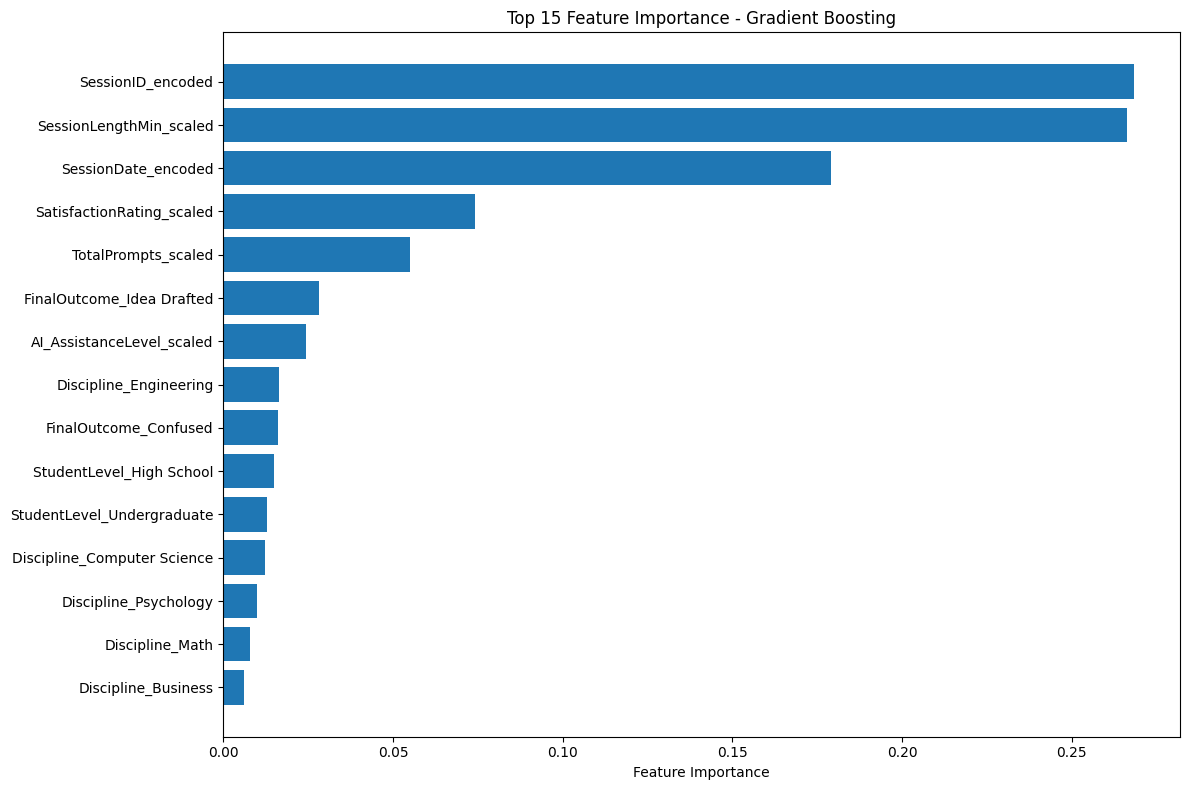


🔄 Calculating permutation importance...
Top 15 Permutation Importance:
                        feature  importance_mean  importance_std
13      SessionLengthMin_scaled         0.270198        0.015294
0             SessionID_encoded         0.253923        0.009762
9           SessionDate_encoded         0.203125        0.016183
16    SatisfactionRating_scaled         0.090405        0.006723
14          TotalPrompts_scaled         0.089452        0.006693
12    FinalOutcome_Idea Drafted         0.065393        0.012099
10        FinalOutcome_Confused         0.032772        0.003261
15    AI_AssistanceLevel_scaled         0.027623        0.006257
2    StudentLevel_Undergraduate         0.027136        0.005310
11         FinalOutcome_Gave Up         0.024145        0.001974
4   Discipline_Computer Science         0.017553        0.002198
5        Discipline_Engineering         0.015964        0.002942
7               Discipline_Math         0.015684        0.002143
1      StudentLeve

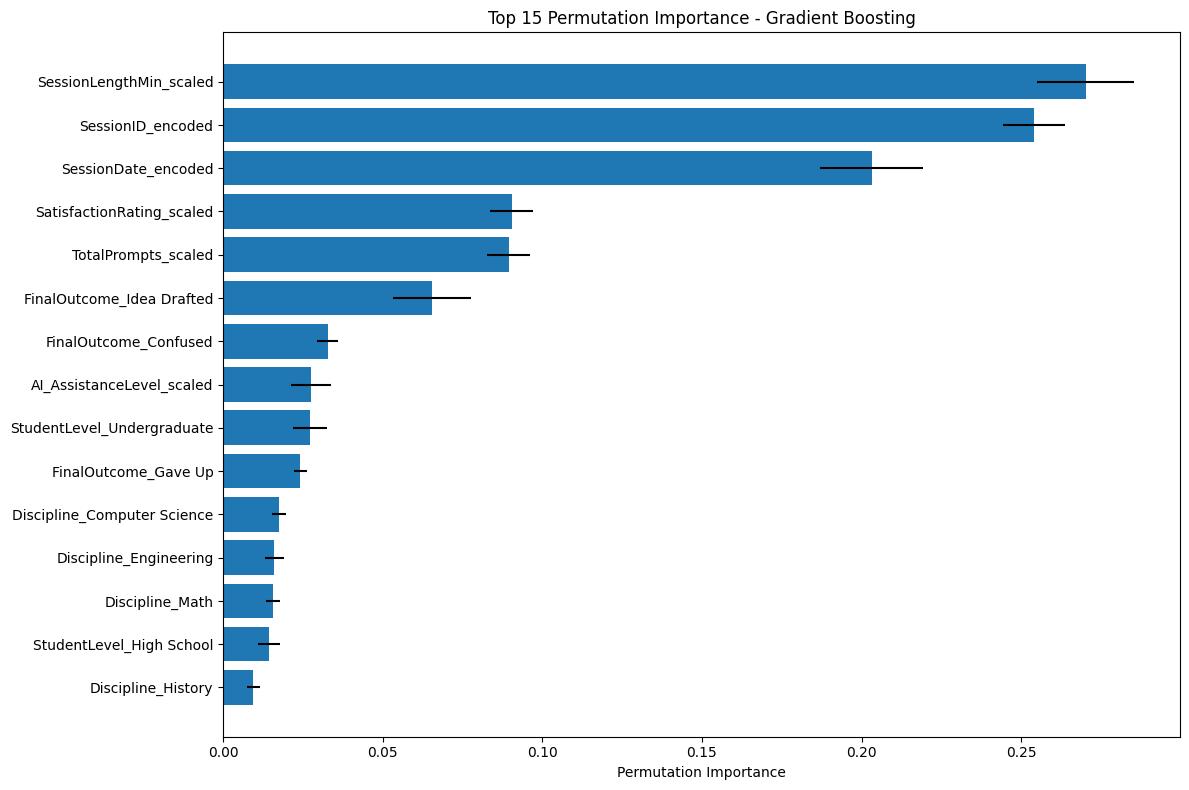

In [ ]:
print("\n" + "="*60)
print("🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Train best model on full dataset for feature analysis
best_model_full = models[best_model_name]
best_model_full.fit(X, y)

# Feature importance analysis
if hasattr(best_model_full, 'feature_importances_'):
    print(f"📊 Analyzing feature importance for {best_model_name}...")

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model_full.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 15 Most Important Features:")
    print(feature_importance.head(15))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Permutation importance (more robust)
print("\n🔄 Calculating permutation importance...")
perm_importance = permutation_importance(
    best_model_full, X, y, n_repeats=5, random_state=42, scoring='f1_weighted'
)

perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print("Top 15 Permutation Importance:")
print(perm_importance_df.head(15))

# Plot permutation importance
plt.figure(figsize=(12, 8))
top_perm_features = perm_importance_df.head(15)
plt.barh(range(len(top_perm_features)), top_perm_features['importance_mean'],
         xerr=top_perm_features['importance_std'])
plt.yticks(range(len(top_perm_features)), top_perm_features['feature'])
plt.xlabel('Permutation Importance')
plt.title(f'Top 15 Permutation Importance - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# **ERROR ANALYSIS**

Kode ini melakukan **analisis kesalahan (error analysis)** dari model terbaik pada data uji untuk memahami pola kesalahan dan kepercayaan prediksi, berikut ringkasan fungsinya:

1. **Membagi dataset**

   * Split `X, y` jadi train (80%) dan test (20%) dengan stratifikasi label agar distribusi kelas tetap terjaga.

2. **Melatih dan melakukan prediksi**

   * Latih model terbaik (`best_model_full`) di data train.
   * Prediksi label (`y_pred`) dan probabilitas prediksi (`y_pred_proba`) pada data test.

3. **Laporan klasifikasi lengkap**

   * Cetak classification report lengkap (precision, recall, f1-score per kelas) dalam bentuk DataFrame.

4. **Matriks kebingungan (confusion matrix)**

   * Hitung dan visualisasikan confusion matrix dengan heatmap agar mudah melihat kelas mana yang paling sering salah diklasifikasikan.

5. **Analisis kesalahan (misclassification)**

   * Identifikasi indeks data yang salah prediksi.
   * Tampilkan total kasus salah prediksi dan persentasenya.
   * Hitung dan tampilkan 5 pasangan kesalahan paling umum (kelas asli → kelas prediksi salah).

6. **Analisis kepercayaan prediksi**

   * Hitung jumlah prediksi dengan confidence < 60%.
   * Tampilkan jumlah dan persentase prediksi rendah kepercayaan.
   * Bandingkan rata-rata confidence untuk prediksi rendah vs tinggi, sebagai indikasi seberapa yakin model pada prediksi yang kurang tepat.

---

**Manfaat analisis ini:**

* Mengetahui kelas mana yang paling sering rancu (misclassified).
* Mengidentifikasi area di mana model tidak yakin (confidence rendah).
* Mempersiapkan langkah perbaikan seperti penambahan data, fitur baru, atau tuning ulang model.


🔍 ERROR ANALYSIS
📋 Detailed Classification Report:
               precision  recall  f1-score  support
Brainstorming      0.000   0.000     0.000    8.000
Coding             0.161   0.122     0.139   41.000
Homework Help      0.167   0.128     0.145   39.000
Research           0.000   0.000     0.000    8.000
Studying           0.327   0.356     0.340   45.000
Writing            0.309   0.424     0.357   59.000
accuracy           0.255   0.255     0.255    0.255
macro avg          0.161   0.172     0.164  200.000
weighted avg       0.230   0.255     0.239  200.000

🔀 Confusion Matrix:
[[ 0  1  2  0  2  3]
 [ 1  5 11  1  5 18]
 [ 1  7  5  1 11 14]
 [ 1  1  0  0  2  4]
 [ 1  7  4  0 16 17]
 [ 3 10  8  0 13 25]]


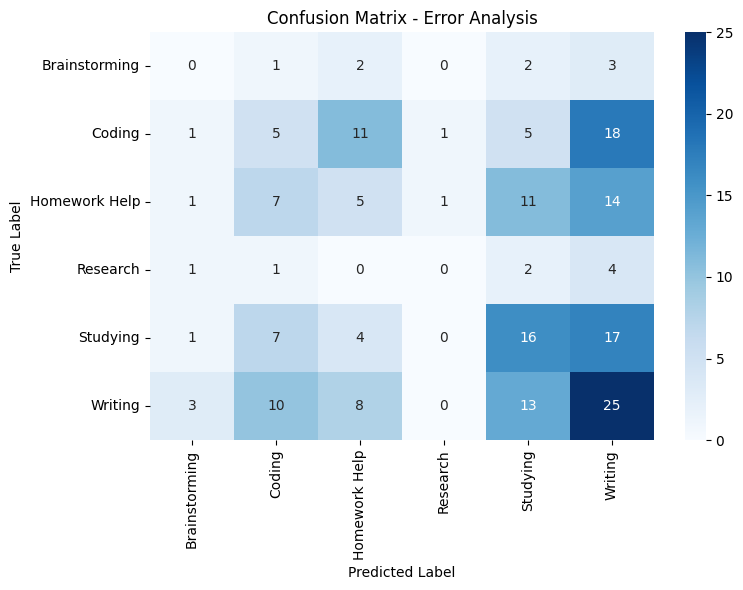


❌ Misclassification Analysis:
Total misclassifications: 149 out of 200 (74.5%)

Most common misclassifications:
  Coding → Writing: 18 cases
  Studying → Writing: 17 cases
  Homework Help → Writing: 14 cases
  Writing → Studying: 13 cases
  Homework Help → Studying: 11 cases

Low confidence predictions (<60%): 179 (89.5%)
  Average confidence (low): 0.396
  Average confidence (high): 0.689


In [ ]:
print("\n" + "="*60)
print("🔍 ERROR ANALYSIS")
print("="*60)

from sklearn.model_selection import train_test_split

# Split data for error analysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train and predict
best_model_full.fit(X_train, y_train)
y_pred = best_model_full.predict(X_test)
y_pred_proba = best_model_full.predict_proba(X_test)

# Detailed classification report
print("📋 Detailed Classification Report:")
report = classification_report(y_test, y_pred, target_names=target_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(3))

# Confusion matrix analysis
cm = confusion_matrix(y_test, y_pred)
print(f"\n🔀 Confusion Matrix:")
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=target_classes, yticklabels=target_classes)
plt.title('Confusion Matrix - Error Analysis')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Misclassification analysis
print(f"\n❌ Misclassification Analysis:")
misclassified_mask = y_test != y_pred
misclassified_indices = np.where(misclassified_mask)[0]

if len(misclassified_indices) > 0:
    print(f"Total misclassifications: {len(misclassified_indices)} out of {len(y_test)} ({len(misclassified_indices)/len(y_test)*100:.1f}%)")

    # Most common misclassifications
    misclass_pairs = [(target_classes[y_test[i]], target_classes[y_pred[i]])
                      for i in misclassified_indices]

    from collections import Counter
    misclass_counter = Counter(misclass_pairs)
    print(f"\nMost common misclassifications:")
    for (true_label, pred_label), count in misclass_counter.most_common(5):
        print(f"  {true_label} → {pred_label}: {count} cases")

    # Low confidence predictions
    prediction_confidence = np.max(y_pred_proba, axis=1)
    low_confidence_mask = prediction_confidence < 0.6
    low_confidence_count = np.sum(low_confidence_mask)

    print(f"\nLow confidence predictions (<60%): {low_confidence_count} ({low_confidence_count/len(y_test)*100:.1f}%)")

    if low_confidence_count > 0:
        avg_confidence_low = np.mean(prediction_confidence[low_confidence_mask])
        avg_confidence_high = np.mean(prediction_confidence[~low_confidence_mask])
        print(f"  Average confidence (low): {avg_confidence_low:.3f}")
        print(f"  Average confidence (high): {avg_confidence_high:.3f}")


# **MODEL STABILITY ANALYSIS**

Kode ini melakukan **analisis kestabilan model** dengan cara mengukur konsistensi performa model terbaik pada berbagai pembagian data acak berbeda. Berikut penjelasan ringkas fungsi dan langkahnya:

1. **Multiple random splits**

   * Data dibagi ulang sebanyak 10 kali (`n_iterations`) secara acak dengan `random_state` berbeda tiap iterasi, tetap menjaga distribusi kelas (`stratify=y`).

2. **Training dan evaluasi tiap split**

   * Model terbaik (`best_model_name`) dilatih di tiap split training.
   * Kemudian diprediksi pada split test, dihitung skor F1 weighted sebagai metrik performa.

3. **Kalkulasi metrik kestabilan**

   * Rata-rata F1-score (`stability_mean`).
   * Standar deviasi F1-score (`stability_std`).
   * Koefisien variasi (CV) = std / mean, sebagai ukuran relatif variasi performa.

4. **Interpretasi kestabilan**

   * Jika CV < 0.05 → model sangat stabil.
   * 0.05 ≤ CV < 0.1 → stabilitas sedang.
   * CV ≥ 0.1 → stabilitas rendah, model kurang konsisten.

5. **Visualisasi**

   * Grafik skor F1 tiap iterasi dengan garis rata-rata dan rentang ±1 stddev.
   * Memudahkan identifikasi seberapa variatif performa model pada berbagai pembagian data.

---

**Tujuan:**
Mengetahui apakah model tetap konsisten performanya saat data train-test diacak ulang, yang penting untuk validasi bahwa model tidak hanya cocok pada satu split tertentu saja.



📊 MODEL STABILITY ANALYSIS
🔄 Testing model stability across 10 random splits...
📊 Stability Results:
   Mean F1-Score: 0.2423
   Standard Deviation: 0.0419
   Coefficient of Variation: 0.1731
   Min F1-Score: 0.1703
   Max F1-Score: 0.3096
❌ Model shows low stability (CV ≥ 0.1)


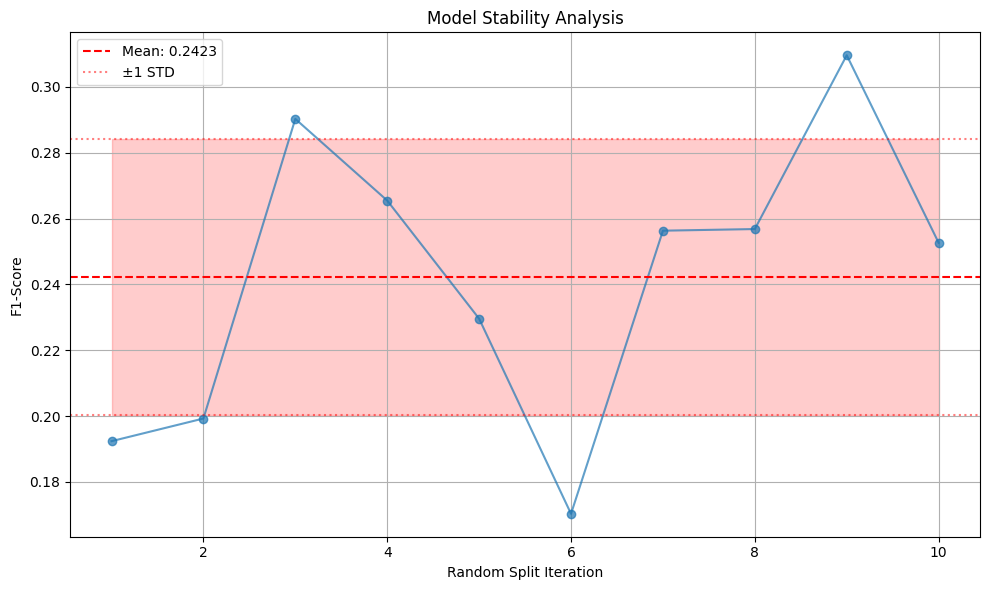

In [ ]:
print("\n" + "="*60)
print("📊 MODEL STABILITY ANALYSIS")
print("="*60)

# Multiple random splits to test stability
stability_scores = []
n_iterations = 10

print(f"🔄 Testing model stability across {n_iterations} random splits...")

for i in range(n_iterations):
    X_train_stab, X_test_stab, y_train_stab, y_test_stab = train_test_split(
        X, y, test_size=0.2, random_state=i, stratify=y
    )

    model_stab = models[best_model_name]
    model_stab.fit(X_train_stab, y_train_stab)
    y_pred_stab = model_stab.predict(X_test_stab)

    f1_stab = f1_score(y_test_stab, y_pred_stab, average='weighted')
    stability_scores.append(f1_stab)

# Stability metrics
stability_mean = np.mean(stability_scores)
stability_std = np.std(stability_scores)
stability_cv = stability_std / stability_mean  # Coefficient of variation

print(f"📊 Stability Results:")
print(f"   Mean F1-Score: {stability_mean:.4f}")
print(f"   Standard Deviation: {stability_std:.4f}")
print(f"   Coefficient of Variation: {stability_cv:.4f}")
print(f"   Min F1-Score: {np.min(stability_scores):.4f}")
print(f"   Max F1-Score: {np.max(stability_scores):.4f}")

if stability_cv < 0.05:
    print("✅ Model shows high stability (CV < 0.05)")
elif stability_cv < 0.1:
    print("⚠️ Model shows moderate stability (0.05 ≤ CV < 0.1)")
else:
    print("❌ Model shows low stability (CV ≥ 0.1)")

# Plot stability
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_iterations+1), stability_scores, 'o-', alpha=0.7)
plt.axhline(y=stability_mean, color='red', linestyle='--', label=f'Mean: {stability_mean:.4f}')
plt.axhline(y=stability_mean + stability_std, color='red', linestyle=':', alpha=0.5, label=f'±1 STD')
plt.axhline(y=stability_mean - stability_std, color='red', linestyle=':', alpha=0.5)
plt.fill_between(range(1, n_iterations+1),
                 stability_mean - stability_std,
                 stability_mean + stability_std, alpha=0.2, color='red')
plt.xlabel('Random Split Iteration')
plt.ylabel('F1-Score')
plt.title('Model Stability Analysis')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **COMPREHENSIVE EVALUATION SUMMARY**

Kode ini menyajikan **ringkasan evaluasi menyeluruh** dari seluruh proses modeling dan analisis performa, termasuk rekomendasi terkait model terbaik. Penjelasannya sebagai berikut:

1. **Informasi Dataset**

   * Jumlah total sampel, jumlah fitur, jumlah kelas target, dan nama kolom target.

2. **Model Terbaik**

   * Nama model dengan skor F1 dan akurasi rata-rata beserta standar deviasi hasil cross-validation.
   * Skor overfitting yang dihitung dari selisih akurasi train dan test.

3. **Analisis Stabilitas**

   * Rata-rata skor F1, standar deviasi, koefisien variasi, serta rating kestabilan (tinggi, sedang, rendah) berdasarkan CV.

4. **Analisis Error**

   * Akurasi pada data uji, tingkat misklasifikasi, dan persentase prediksi dengan confidence rendah.

5. **Rekomendasi Model**

   * Penegasan model terbaik dan performanya.
   * Saran jika ada indikasi overfitting untuk mempertimbangkan regularisasi.
   * Catatan kestabilan model dan peluang perbaikan.
   * Fitur paling penting (jika sudah dihitung).
   * Akurasi akhir pada data uji.

6. **Output**

   * Cetak ringkasan dengan struktur rapi dan jelas.
   * Menyampaikan kesiapan untuk langkah berikutnya yaitu membuat dashboard visualisasi akhir.


In [ ]:
print("\n" + "="*60)
print("📊 COMPREHENSIVE EVALUATION SUMMARY")
print("="*60)

# Create final evaluation report
evaluation_summary = {
    'Dataset Info': {
        'Total Samples': len(X),
        'Features': X.shape[1],
        'Classes': len(target_classes),
        'Target Variable': target_col
    },
    'Best Model': {
        'Model Name': best_model_name,
        'CV F1-Score': f"{comparison_df.loc[best_model_idx, 'Test_F1_Mean']:.4f} (±{comparison_df.loc[best_model_idx, 'Test_F1_Std']:.4f})",
        'CV Accuracy': f"{comparison_df.loc[best_model_idx, 'Test_Accuracy_Mean']:.4f} (±{comparison_df.loc[best_model_idx, 'Test_Accuracy_Std']:.4f})",
        'Overfitting Score': f"{comparison_df.loc[best_model_idx, 'Overfitting_Score']:.4f}"
    },
    'Stability Analysis': {
        'Mean F1-Score': f"{stability_mean:.4f}",
        'Standard Deviation': f"{stability_std:.4f}",
        'Coefficient of Variation': f"{stability_cv:.4f}",
        'Stability Rating': 'High' if stability_cv < 0.05 else 'Moderate' if stability_cv < 0.1 else 'Low'
    },
    'Error Analysis': {
        'Test Accuracy': f"{accuracy_score(y_test, y_pred):.4f}",
        'Misclassification Rate': f"{len(misclassified_indices)/len(y_test)*100:.1f}%",
        'Low Confidence Predictions': f"{low_confidence_count/len(y_test)*100:.1f}%" if 'low_confidence_count' in locals() else 'N/A'
    }
}

print("📋 FINAL EVALUATION REPORT")
print("=" * 50)
for category, metrics in evaluation_summary.items():
    print(f"\n🔸 {category}:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value}")

# Model recommendations
print(f"\n💡 RECOMMENDATIONS:")
print(f"1. 🏆 Best model: {best_model_name} with F1-Score {comparison_df.loc[best_model_idx, 'Test_F1_Mean']:.4f}")

if comparison_df.loc[best_model_idx, 'Overfitting_Score'] > 0.1:
    print(f"2. ⚠️ Model shows overfitting (score: {comparison_df.loc[best_model_idx, 'Overfitting_Score']:.4f}) - consider regularization")
else:
    print(f"2. ✅ Model shows good generalization (overfitting score: {comparison_df.loc[best_model_idx, 'Overfitting_Score']:.4f})")

if stability_cv < 0.05:
    print(f"3. ✅ Model is highly stable across different data splits")
else:
    print(f"3. ⚠️ Model stability could be improved (CV: {stability_cv:.4f})")

if 'top_features' in locals():
    top_feature = feature_importance.iloc[0]['feature']
    print(f"4. 🎯 Most important feature: {top_feature}")

print(f"5. 📊 Model achieves {accuracy_score(y_test, y_pred)*100:.1f}% accuracy on test data")

print(f"\n✅ Comprehensive Model Evaluation Completed!")
print(f"🚀 Ready for final visualization dashboard!")


📊 COMPREHENSIVE EVALUATION SUMMARY
📋 FINAL EVALUATION REPORT

🔸 Dataset Info:
   Total Samples: 1000
   Features: 17
   Classes: 6
   Target Variable: TaskType

🔸 Best Model:
   Model Name: Gradient Boosting
   CV F1-Score: 0.2588 (±0.0380)
   CV Accuracy: 0.2760 (±0.0410)
   Overfitting Score: 0.6130

🔸 Stability Analysis:
   Mean F1-Score: 0.2423
   Standard Deviation: 0.0419
   Coefficient of Variation: 0.1731
   Stability Rating: Low

🔸 Error Analysis:
   Test Accuracy: 0.2550
   Misclassification Rate: 74.5%
   Low Confidence Predictions: 89.5%

💡 RECOMMENDATIONS:
1. 🏆 Best model: Gradient Boosting with F1-Score 0.2588
2. ⚠️ Model shows overfitting (score: 0.6130) - consider regularization
3. ⚠️ Model stability could be improved (CV: 0.1731)
4. 🎯 Most important feature: SessionID_encoded
5. 📊 Model achieves 25.5% accuracy on test data

✅ Comprehensive Model Evaluation Completed!
🚀 Ready for final visualization dashboard!
